<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2021notebooks/2021_0702rnn_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN による言語モデルのデモ
- author: 浅川伸一
- date: 2021_0702
- filename: 2021_0702rnn_demo.ipynb


In [6]:
%config InlineBackend.figure_format = 'retina'
import torch
try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade > /dev/null 2>&1
    !git clone https://github.com/ShinAsakawa/bit.git
    import bit

HOME = bit.HOME
isColab = bit.isColab
    
#図中に日本語の説明を入れるためのライブラリをインストール
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

日付: 2022-09-15
HOSTNAME: Sinope
ユーザ名: _asakawa
HOME: /Users/_asakawa
ファイル名: study/2022komazawa-deep-learning_komazawa-deep-learning.github.io/2021notebooks/2021_0702rnn_demo.ipynb
torch.__version__: 1.12.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt

#ソフトマックス関数の定義
def softmax(x, beta=1):
    xt = np.exp(beta * x - np.mean(beta * x))
    return xt / np.sum(xt)

In [3]:
class srn_model():
    
    def __init__(self,
                 n_hid = 200,         #中間層のサイズ
                 lr = 1e-1,           #学習率
                 max_epochs=10 ** 3,  #最大エポック数
                 interval=None,       #途中結果の表示タイミング
                 plot=True, 
                 cont=False, 
                 text=None,
                 generate_text=True,
                 chr2idx=None):
    
        # ハイパーパラメータ
        self.n_hid = n_hid             # 中間層のニューロン数
        self.lr = lr
        self.plot = plot
        self.chr2idx = chr2idx
        self.max_epochs = max_epochs
        self.interval = interval if interval != None else self.max_epochs >> 3
        self.generate_text = generate_text
        self.smooth_loss = None
        self.looses = []
        
        if text == None: #何も指定されていない場合，データを用意する
            text = """
日本国民は、正義と秩序を基調とする国際平和を誠実に希求し、\n
国権の発動たる戦争と、武力による威嚇又は武力の行使は、\n
国際紛争を解決する手段としては、永久にこれを放棄する。\n
前項の目的を達するため、陸海空軍その他の戦力は、\n
これを保持しない。\n
国の交戦権は、これを認めない。"""
            text = text.split()

        self.text = text
        self.seq_len = len(self.text)

        if self.chr2idx == None:
            self.make_chr2idx(text)
        else:
            self.idx2char = {i:c for i,c in self.chr2idx}

        self.X = np.zeros((len(text), self.max_len), dtype=np.uint)
        ones = np.ones((len(text),1), dtype=np.uint)
        self.X = np.concatenate((ones, self.X), axis=1)
        for i, line in enumerate(text):
            for j, chr in enumerate(line):
                self.X[i,j] = self.chr2idx[chr]

        # 結合係数行列とバイアス項の初期化
        self.Wxh = np.random.randn(self.n_hid, self.n_vocab) / np.sqrt(self.n_vocab + self.n_hid)  # input to hidden
        self.Whh = np.random.randn(self.n_hid, self.n_hid) / np.sqrt(self.n_hid + self.n_hid)      # hidden to hidden
        self.Why = np.random.randn(self.n_vocab, self.n_hid) / np.sqrt(self.n_hid + self.n_vocab)  # hidden to output
        self.bh = np.zeros((self.n_hid, 1))                                          # hidden bias
        self.by = np.zeros((self.n_vocab, 1))                                        # output bias
            

    def make_chr2idx(self, text):
        #chars = ['<eow>', '<sow>']  # <eow>: end of word, <sow>: start of word
        chars = ['<eow>']             # <eow>: end of word, <sow>: start of word
        for line in text:
            [chars.append(chr) for chr in line]
        
        self.all_chars = set(chars)
        self.n_vocab = len(self.all_chars)
        
        self.chr2idx, self.idx2chr = {}, {}
        self.chr2idx['<eow>'] = 0   #, self.chr2idx['<sow>'] = 0, 1
        self.idx2chr[0] = '<eow>'   #, self.idx2chr[1] = '<eow>', '<sow>'
        idx = 1                     #+1 <eow> # +2 にしていあるのは <eow> <sow> のため
        max_len = 0
        for line in text:
            if max_len < len(line):
                max_len = len(line)
            for chr in line:
                if not chr in self.chr2idx:
                    self.chr2idx[chr] = idx 
                    self.idx2chr[idx] = chr
                    idx += 1
                
        self.max_len =  max_len + 1  # +1 にしていあるのは <eow> のため

    
    def init_memory(self):
        # m で始まる変数は，Adagrad で用いるメモリ変数。
        self.mWxh = np.zeros_like(self.Wxh)  # mWxh: 入力から中間層への結合係数行列
        self.mWhh = np.zeros_like(self.Whh)  # mWhh: 中間層へのリカレント結合係数行列
        self.mWhy = np.zeros_like(self.Why)  # mWhy: 中間層から出力層への結合係数行列
        self.mbh = np.zeros_like(self.bh)    # mbh: 中間層のバイアス項
        self.mby = np.zeros_like(self.by)    # mby: 出力層のバイアス項

    
    def forward(self, inputs, targets, h_prev):
        """inputs,targets are both list of integers.
        hprev is Hx1 array of initial hidden state
        returns the loss, gradients on model parameters, and last hidden state
        """
        x, h, y, prob = {}, {}, {}, {}
        h[-1] = np.copy(h_prev)
        loss = 0
        for t in range(len(inputs)):
            x[t] = np.zeros((self.n_vocab,1)) # encode in 1-of-k representation
            x[t][inputs[t]] = 1
            
            h[t] = np.tanh(np.dot(self.Wxh, x[t]) 
                           + np.dot(self.Whh, h[t-1]) 
                           + self.bh)
            y[t] = np.dot(self.Why, h[t]) + self.by  # unnormalized log probabilities for next chars
            prob[t] = softmax(y[t]) 
            loss += -np.log(prob[t][targets[t],0])   # softmax (cross-entropy loss)  

        return loss, x, h, y, prob


    def backward(self, inputs, targets, hprev, x_, h_, y_, prob_):
        """backward pass: compute gradients going backwards"""
        dWxh, dWhh, dWhy = np.zeros_like(self.Wxh), np.zeros_like(self.Whh), np.zeros_like(self.Why)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h_[0])
    
        for t in reversed(range(len(inputs))):
            dy = np.copy(prob_[t])
            dy[targets[t]] -= 1      
            dWhy += np.dot(dy, h_[t].T)
            dby += dy
            
            dh = np.dot(self.Why.T, dy) + dhnext  # backprop into h
            delta = (1 - h_[t] * h_[t]) * dh      # backprop through tanh nonlinearity
            
            dbh  += delta
            dWxh += np.dot(delta, x_[t].T)
            dWhh += np.dot(delta, h_[t-1].T)
            dhnext = np.dot(self.Whh.T, delta)
                    
        for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
        
        return dWxh, dWhh, dWhy, dbh, dby, h_[len(inputs)-1]
    
    
    def sample(self, hprev, seed, n):
        """ 
        sample a sequence of integers from the model 
        h is memory state, seed_ix is seed letter for first time step
        """
        x = np.zeros((self.n_vocab, 1))
        hid = hprev
        x[seed] = 1
        idxes = []
        for t in range(n):
            hid = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, hid) + self.bh)
            out = np.dot(self.Why, hid) + self.by
            prob = softmax(out)
            idx = np.random.choice(range(self.n_vocab), p=prob.ravel())
            x = np.zeros((self.n_vocab, 1))
            x[idx] = 1
            idxes.append(idx)
        return idxes

    
    def generate(self, hprev, seed, n):
        """generate a sequence of integers from the model 
        h is memory state, seed_ix is seed letter for first time step
        """
        x = np.zeros((self.n_vocab, 1))
        hid = hprev
        x[seed] = 1
        idxes = []
        for t in range(n):
            hid = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, hid) + self.bh)
            out = np.dot(self.Why, hid) + self.by
            prob = softmax(out)
            idx = np.argmax(prob)
            x = np.zeros((self.n_vocab, 1))
            x[idx] = 1
            idxes.append(idx)
        return idxes


    def draw_loss_plot(self, losses):
        plt.xlabel('訓練回数'); plt.ylabel('損失'); plt.title('損失値の変化')
        plt.plot(losses); plt.show()


    def all_text_generation(self):
        for i_ in range(len(self.X)):
            line = self.X[i_]
            hprev = np.zeros((self.n_hid,1)) # reset RNN memory
            h_prev = np.zeros((self.n_hid, 1))
                
            stop_no = line.tolist().index(self.chr2idx['<eow>'])
            inputs = line[:stop_no]
            sample_idx = self.generate(h_prev, inputs[0], self.X.shape[1])
            out_txt = self.idx2chr[inputs[0]]
            for idx in sample_idx:
                ch = self.idx2chr[idx]
                if ch == '<eow>':
                    break
                else:
                    out_txt += ch
            print(i_, out_txt)


    def train(self, plot=None, generate_text=None, max_epochs=None, interval=None):
        self.plot = plot if plot != None else self.plot
        self.generate_text = generate_text if generate_text != None else self.generate_text
        if max_epochs != None:
            self.max_epochs = max_epochs
            
        if interval != None:
            self.interval = interval

        if self.smooth_loss == None:
            self.smooth_loss = -np.log(1.0/self.n_vocab) * len(self.X) * self.max_len
            self.losses = []
            self.init_memory()
        
        for epoch in range(self.max_epochs):
            idxes = np.random.permutation(len(self.X))  # シャッフル
            t_loss = 0
            for num in range(len(self.X)):
                line = self.X[idxes[num]]
                
                seq, seq_no = [], 0
                stop_no = line.tolist().index(self.chr2idx['<eow>'])
                inputs = line[:stop_no]
                targets = line[1:stop_no+1]

                # forward seq_len characters through the net and fetch gradient
                h_prev = np.zeros((self.n_hid,1))
                loss, x, h, y, prob = self.forward(inputs, targets, h_prev)
                t_loss += loss
                dWxh, dWhh, dWhy, dbh, dby, h = self.backward(inputs, targets, h_prev, x, h, y, prob)
    
                # perform parameter update with Adagrad
                for param, delta, Hessian in zip([self.Wxh, self.Whh, self.Why, self.bh, self.by], 
                                                  [dWxh, dWhh, dWhy, dbh, dby], 
                                                  [self.mWxh, self.mWhh, self.mWhy, self.mbh, self.mby]):
                    Hessian += delta * delta
                    param += -self.lr * delta / np.sqrt(Hessian + 1e-8) # adagrad update
            
                self.smooth_loss = self.smooth_loss * 0.999 + t_loss * 0.001
                self.losses.append(self.smooth_loss)
 
            if epoch % self.interval == 0:
                h_prev = np.zeros((self.n_hid,1))
                sample_ix = self.sample(h_prev, inputs[0], 30)
                txt = ''.join(self.idx2chr[ix] for ix in sample_ix)
                #txt = re.sub('<eow>','\n',txt)
                print(f'--- 反復訓練数={epoch} 損失値: {self.smooth_loss:.3f} ---\n{txt}')

        print(f'--- 最終反復訓練数={epoch} 損失値: {self.smooth_loss:.3f} ---\n{txt}')
        if self.generate_text: self.all_text_generation()
        if self.plot: self.draw_loss_plot(self.losses)
        return {'Wxh':self.Wxh, 'Whh':self.Whh, 'Why':self.Why, 'bh':self.bh, 'by':self.by}


--- 反復訓練数=0 損失値: 767.189 ---
義目義<eow>使際行目た項誠紛よ項秩久のここす目の調放民はの実放使
--- 反復訓練数=125 損失値: 370.935 ---
際紛争を解決する手段としては、永久にこれを放棄する。<eow>海た海
--- 反復訓練数=250 損失値: 176.744 ---
権の発動たる戦争と、武力による威嚇又は武力の行使は、<eow>れする
--- 反復訓練数=375 損失値: 84.818 ---
れを保持しない。<eow>動たるたる放空実ない。<eow>は陸力本国民は、正
--- 反復訓練数=500 損失値: 41.288 ---
権の発動たる戦争と、武力による威嚇又は武力の行使は、<eow>れ戦権
--- 反復訓練数=625 損失値: 20.643 ---
れを保持しない。<eow>義威力武力の行使は、<eow>は、<eow>久嚇認めとする
--- 反復訓練数=750 損失値: 10.911 ---
れを保持しない。<eow>動たる戦争と、これを認めない。<eow>平戦武力認
--- 反復訓練数=875 損失値: 6.329 ---
項の目的を達するため、陸海空軍その他の戦力は、<eow>久にるたる戦
--- 最終反復訓練数=999 損失値: 4.105 ---
項の目的を達するため、陸海空軍その他の戦力は、<eow>久にるたる戦
0 日本国民は、正義と秩序を基調とする国際平和を誠実に希求し、
1 国際紛争を解決する手段としては、永久にこれを放棄する。
2 国際紛争を解決する手段としては、永久にこれを放棄する。
3 前項の目的を達するため、陸海空軍その他の戦力は、
4 これを保持しない。
5 国際紛争を解決する手段としては、永久にこれを放棄する。


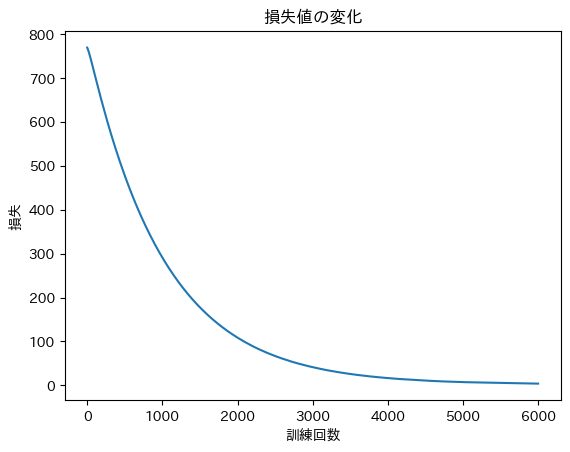

In [4]:
model = srn_model(max_epochs=10 ** 3, n_hid=20) #, generate_text=False, plot=False) 
_ = model.train(max_epochs=10 ** 3, plot=True)

--- 反復訓練数=0 損失値: 2212.026 ---
理せてもだ負っめを掴酔み止れれをそる連も<eow>るいの連て掴くれけ
--- 反復訓練数=12 損失値: 1728.286 ---
<eow>なれるな咲を<eow>れて　僕泥ばる命由の知ったなう　みってなら　
--- 反復訓練数=24 損失値: 1328.996 ---
はる手きうだ打進意<eow>を知ったけさ<eow>なれけ　運<eow>を手らで理由を
--- 反復訓練数=36 損失値: 1016.700 ---
わ知ったけるな味ち分灯<eow>　分自ばみたはるれたしけ<eow>連れて進め
--- 反復訓練数=48 損失値: 777.086 ---
<eow>なれる理そ<eow>だめされなれ！　僕だた！さを連れて進め<eow>なら！
--- 反復訓練数=60 損失値: 593.663 ---
<eow>ならけて<eow><eow>なら　け<eow>を照らして！<eow>なれ！　手をにとう　こ
--- 反復訓練数=72 損失値: 453.739 ---
くなれる理由を知った　僕を連れてなれ　それて知め由を睨め今自
--- 反復訓練数=84 損失値: 347.049 ---
<eow>なれる理由を知った　僕の連れて進め<eow>れて！連れをてけ　僕れ
--- 反復訓練数=96 損失値: 265.710 ---
<eow>なれる理由を知った　僕を連れて進め<eow>を運れて夢け　止まれな
--- 最終反復訓練数=99 損失値: 248.654 ---
<eow>なれる理由を知った　僕を連れて進め<eow>を運れて夢け　止まれな
0 強
1 強
2 泥だらけの走馬灯に酔う　こわばる心
3 強
4 震える手は掴みたいものがある　それだけさ
5 強
6 夜の匂いに空睨んでも
7 強
8 変わっていけるのは自分自身だけ　それだけさ
9 強
10 強
11 強
12 どうしたって！
13 強
14 消せない夢も　止まれない今も
15 強
16 誰かのために強くなれるなら
17 強
18 ありがとう　悲しみよ
19 強
20 世界に打ちのめされて負ける意味を知った
21 強
22 紅蓮の華よ咲き誇れ！　運命を照らして


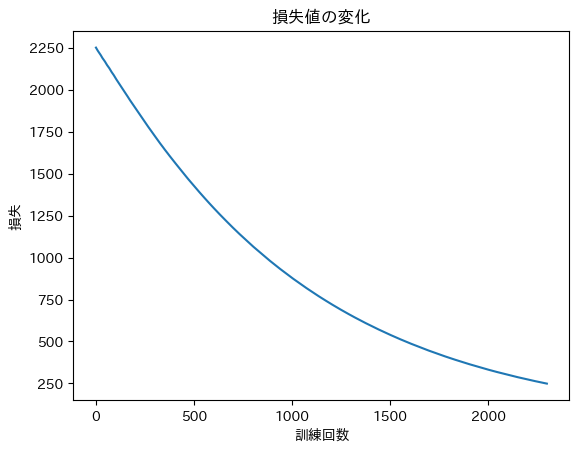

In [5]:
gurenge = """強くなれる理由を知った　僕を連れて進め\n
泥だらけの走馬灯に酔う　こわばる心\n
震える手は掴みたいものがある　それだけさ\n
夜の匂いに空睨んでも\n
変わっていけるのは自分自身だけ　それだけさ\n
強くなれる理由を知った　僕を連れて進め\n
どうしたって！\n
消せない夢も　止まれない今も\n
誰かのために強くなれるなら\n
ありがとう　悲しみよ\n
世界に打ちのめされて負ける意味を知った\n
紅蓮の華よ咲き誇れ！　運命を照らして"""

# 外部でデータを定義したときのテスト
X = gurenge.split('\n')
#print(X)

model = srn_model(text=X, max_epochs=10 ** 2, n_hid=16, lr=1e-1)
#_ = model.train(plot=False)
_ = model.train(plot=True)

# 外部ファイルを読み込んだときのテスト
# X = open('hosomichi.txt').read().strip().split('\n')
# print(X)
# model = onomatope_generator(text=X, max_epochs=10 ** 2, lr=1e-1)
# model.train()
